# About Python Wavelet, please refer the following URL
#http://pycwt.readthedocs.io/en/latest/tutorial.html
#http://paos.colorado.edu/research/wavelets/software.html
#we will follow the approach suggested by Torrence and Compo (1998)[1]
Torrence, C. and Compo, G. P.. A Practical Guide to Wavelet Analysis. Bulletin of the American Meteorological Society, American Meteorological Society, 1998, 79, 61-78.
#第一步載入需要的模組與資料

In [15]:
# -*- coding: utf-8 -*-
from __future__ import division
import pandas as pd
import sys
from matplotlib import pyplot
import numpy 
import pycwt as wavelet
from pycwt.helpers import find

#使用pandas模組讀取excel資料;u表示unicode編碼;sheetname=1表示第二張工作表，0表示第一張;skiprows=3表示前四行略過
df = pd.read_excel(u'K:\\20171027資料前處理\\溫度分級20171117\\冷暖半年_三區_單一溫度分級\\17-溫度分級-分區時間序列(冷暖半年三區單一溫度分級)-20171227.xlsx',sheetname=3,skiprows=2)
#df = pd.read_excel(u'K:\\20171027資料前處理\\頻率分母計算\\17-溫度分級-分區時間序列(冷暖半年三區單一溫度分級)-20180104.xlsx',sheetname=3,skiprows=2)

#df = pd.read_excel(u'K:\\20171027資料前處理\\20180202\\Reachs_precip_temp_1644-1911.xlsx',sheetname=0)
#顯示前5行資料
df.head()

,年,North_annual,Centrl_annual,South_annual,North_Winter,Central_winter,South_winter,North_summer,Central_summer,South_summer
0,1644,-1.600000,-1.714286,0.0,-1.500000,-1.500000,0.0,-1.375,-1.0,0.0
1,1645,-1.500000,-1.222222,0.0,-1.000000,-1.000000,0.0,-1.500,-1.0,0.0
2,1646,-1.000000,-0.800000,0.0,-1.500000,0.250000,0.0,-1.000,-0.5,0.0
3,1647,-1.666667,-0.600000,0.0,-1.333333,-2.000000,0.0,-1.000,-1.0,0.0
4,1648,-1.166667,-1.000000,0.0,-0.857143,-1.571429,0.0,-1.000,-1.0,0.0


設定標題、資料的時間解析度

In [16]:
title = 'Summer Temperature 1644-1911 North China(Index)'

label = ''
units = 'Index'
t0 = 1644.0
dt = 1.0  # In years

 dat 可設置為華北、華中或華南之時間序列資料 
 N 為資料的長度
 t create a time array in years.

In [17]:
#dat = df.iloc[:,7]華北夏季溫度

dat = df.iloc[:,7]
N = len(df) 
t = numpy.arange(0, N) * dt + t0
dat

0     -1.375000
1     -1.500000
2     -1.000000
3     -1.000000
4     -1.000000
5     -1.000000
6      0.000000
7      0.000000
8     -1.400000
9      0.000000
10    -1.800000
11    -1.681818
12    -1.500000
13    -0.750000
14    -1.250000
15    -2.000000
16    -1.000000
17     0.666667
18    -1.000000
19    -2.000000
20    -1.176471
21    -1.071429
22    -1.666667
23    -0.750000
24    -1.800000
25    -1.000000
26    -1.750000
27     0.176471
28    -1.285714
29    -0.750000
         ...   
238   -0.666667
239   -0.500000
240   -1.600000
241   -1.000000
242   -1.750000
243   -1.250000
244   -0.714286
245   -1.600000
246   -0.833333
247   -1.166667
248   -1.800000
249    1.000000
250   -1.000000
251   -1.333333
252   -2.000000
253   -1.000000
254    0.000000
255   -0.400000
256   -0.846154
257   -0.400000
258   -0.250000
259   -1.250000
260   -1.250000
261    0.000000
262   -1.000000
263    1.000000
264   -1.500000
265   -1.000000
266   -1.000000
267   -1.400000
Name: North_summer, Leng

#numpy.polyfit 求出線性回歸問題之最小平方估測 https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
#numpy.polyval(p,s) 計算p(s)在點s的值 https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyval.html
#We write the following code to detrend and normalize the input data by its standard deviation. Sometimes detrending is not necessary and simply removing the mean value is good enough. However, if your dataset has a well defined trend, such as the Mauna Loa CO2 dataset available in the above mentioned website, it is strongly advised to perform detrending. Here, we fit a one-degree polynomial function and then subtract it from the original data.

In [18]:
p = numpy.polyfit(t - t0, dat , 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

The next step is to define some parameters of our wavelet analysis. We select the mother wavelet, in this case the Morlet wavelet with ω0=6.

from command "help(wavelet)",

cwt(signal, dt, dj=0.08333333333333333, s0=-1, J=-1, wavelet=u'morlet', freqs=None)
        Continuous wavelet transform of the signal at specified scales.
        
        Parameters
        ----------
        signal : numpy.ndarray, list
            Input signal array.
        dt : float
            Sampling interval.
        dj : float, optional
            Spacing between discrete scales. Default value is 1/12.
            Smaller values will result in better scale resolution, but
            slower calculation and plot.
        s0 : float, optional
            Smallest scale of the wavelet. Default value is 2*dt.
        J : float, optional
            Number of scales less one. Scales range from s0 up to
            s0 * 2**(J * dj), which gives a total of (J + 1) scales.
            Default is J = (log2(N * dt / so)) / dj.
        wavelet : instance of Wavelet class, or string
            Mother wavelet class. Default is Morlet wavelet.
        freqs : numpy.ndarray, optional
            Custom frequencies to use instead of the ones corresponding
            to the scales described above. Corresponding scales are
            calculated using the wavelet Fourier wavelength.
        

In [19]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 1 years = 2years
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# The following routines perform the wavelet transform and inverse wavelet transform using the parameters defined above. Since we have normalized our input time-series, we multiply the inverse transform by the standard deviation.

In [20]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# We calculate the normalized wavelet and Fourier power spectra, as well as the Fourier equivalent periods for each wavelet scale.

In [21]:
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# Optionally, we could also rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)
Liu, Y., Liang, X. S. and Weisberg, R. H. Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 2007, 24, 2093-2102.

In [22]:
power /= scales[:, None]

# We could stop at this point and plot our results. However we are also interested in the power spectra significance test. The power is significant where the ratio power / sig95 > 1.

In [23]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its significance level.

In [24]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
#glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                        significance_level=0.95, dof=dof,
#                                        wavelet=mother)
glbl_signif95, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)
glbl_signif90, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.90, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its significance level.

In [25]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the (i) original series anomaly and the inverse wavelet transform; (ii) the wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and (iv) the range averaged wavelet spectrum. In all sub-plots the significance levels are either included as dotted lines or as filled contour lines.

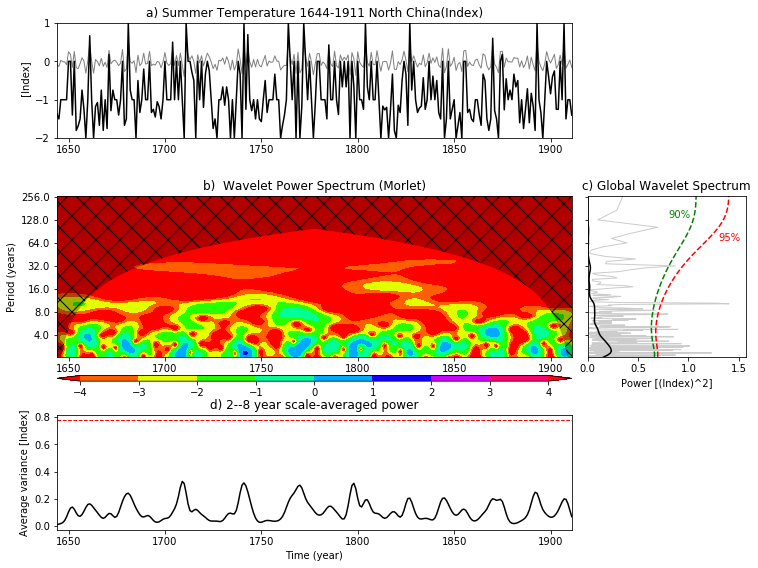

In [32]:
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))
ax.set_ylim(-2,1)

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
CS = bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap='hsv')

extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)
cax = fig.add_axes([0.1, 0.328, 0.65, 0.01])
pyplot.colorbar(CS, cax=cax, orientation='horizontal')

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
#cx.plot(glbl_signif, numpy.log2(period), 'r--')
cx.plot(glbl_signif95, numpy.log2(period), 'r--')
cx.plot(glbl_signif90, numpy.log2(period), 'g--')
cx.text(1.3,6.1,"95%",color="red")
cx.text(0.8,7.1,"90%",color="green")
#cx.plot(var * fft_theor, numpy.log2(period), '--', color='#dae512')

cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var +0.6])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='r', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

#pyplot.savefig(u'K:\\20171027資料前處理\\溫度分級20171117\\冷暖半年_三區_單一溫度分級\\Summer_Temperature_1644-1911_North_China_wavelet.jpg')
